In [ ]:
# Task 3 - Support Vector Machines (SVM)
import sys
from pathlib import Path

ROOT = Path.cwd().parents[1] 
sys.path.append(str(ROOT / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from utils import savefig, evaluate_svm  # ← disse har du laget tidligere
from paths import OUTPUTS

RNG = 42 #sets a fixed random seed so that splitting the dataset into training, validation, and test sets produce the same results every time the code is run

In [9]:
# --- Load dataset ---
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# --- Split (identisk til tidligere) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=RNG
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RNG
)

# --- Standardize (fit on training only, same as before) ---
scaler = StandardScaler().fit(X_train)
X_train_s = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_val_s = pd.DataFrame(scaler.transform(X_val), columns=X.columns)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# --- Cross-validation setup ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

Linear SVM – Accuracy: 0.9648 ± 0.0118
RBF SVM – Accuracy: 0.9707 ± 0.0091


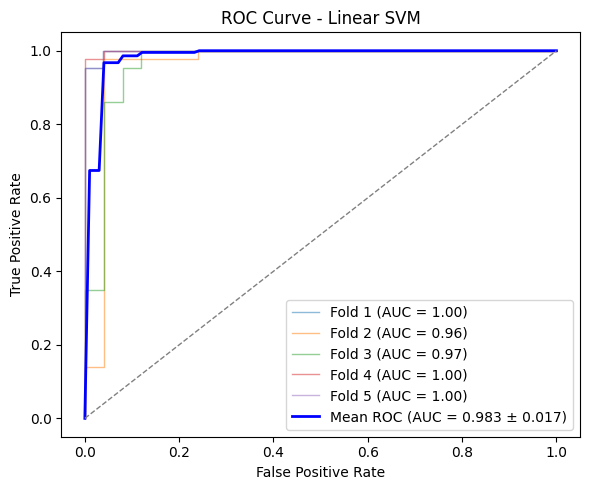

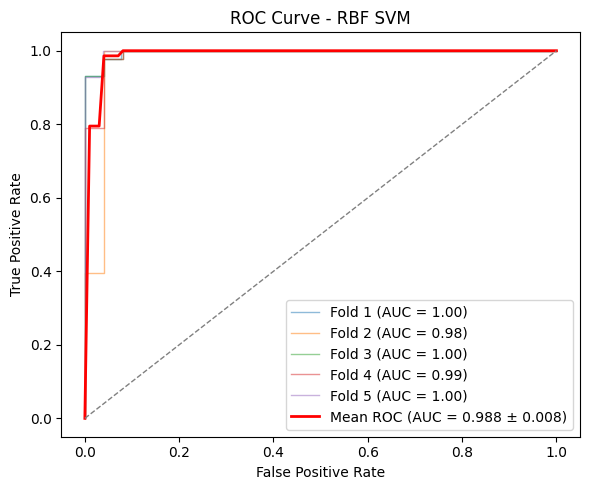

In [10]:
svm_linear = SVC(kernel="linear", random_state=RNG)
fig, auc_linear, std_auc_linear, acc_linear, std_acc_linear = evaluate_svm(
    svm_linear, X_train_s, y_train, cv, "Linear SVM", "blue"
)

print(f"Linear SVM – Accuracy: {acc_linear:.4f} ± {std_acc_linear:.4f}")

svm_rbf = SVC(kernel="rbf", random_state=RNG)
fig, auc_rbf, std_auc_rbf, acc_rbf, std_acc_rbf = evaluate_svm(
    svm_rbf, X_train_s, y_train, cv, "RBF SVM", "red"
)

print(f"RBF SVM – Accuracy: {acc_rbf:.4f} ± {std_acc_rbf:.4f}")


SVMs work by finding an optimal hyperplane that separates data points of different classes with the largest possible margin.
The Linear SVM uses a linear kernel, meaning it assumes the data can be separated by a straight line (or a flat hyperplane in higher dimensions).
The RBF SVM (Radial Basis Function) uses a nonlinear kernel, allowing it to model more complex relationships by mapping data into a higher-dimensional space.

Both models perform exceptionally well, with AUC values close to 1.0 and very small standard deviations — indicating high stability and strong generalization across folds.
The RBF SVM achieves slightly higher accuracy and AUC, showing it captures subtle nonlinear patterns in the data that the linear model cannot.
However, the difference is marginal, suggesting that the dataset is almost linearly separable, making the linear kernel already a strong choice with lower computational cost.

,C,mean_acc,std_acc
0,0.01,0.970673,0.009302
1,0.10,0.973572,0.017179
2,1.00,0.964791,0.011808
3,10.00,0.961935,0.014765
4,100.00,0.953112,0.010826


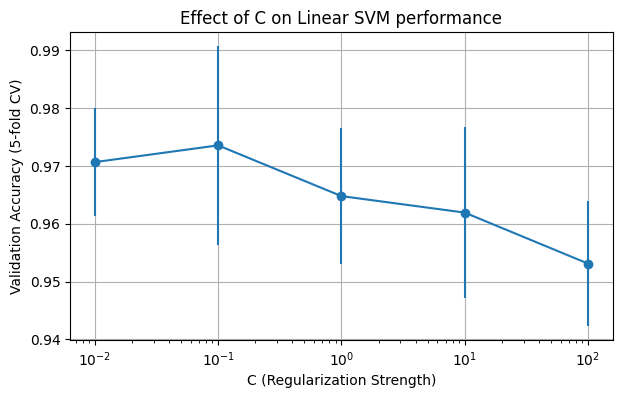

In [24]:
C_values = [0.01, 0.1, 1, 10, 100]
results = []

for C in C_values:
    svm = SVC(kernel="linear", C=C, random_state=RNG)
    scores = cross_val_score(svm, X_train_s, y_train, cv=cv, scoring="accuracy")
    results.append((C, scores.mean(), scores.std()))

df_C = pd.DataFrame(results, columns=["C", "mean_acc", "std_acc"])
display(df_C)
df_C.to_csv(OUTPUTS / "svm_C_results.csv", index=False)

plt.figure(figsize=(7,4))
plt.errorbar(df_C["C"], df_C["mean_acc"], yerr=df_C["std_acc"], fmt='-o')
plt.xscale("log")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("Validation Accuracy (5-fold CV)")
plt.title("Effect of C on Linear SVM performance")
plt.grid(True)
savefig("effect_c_on_LinearSVM")
plt.show()


C controls how much the model tries to classify everything right

C=0.1 is therefore best, because it gives the highest mean accuracy on 0.973572

,gamma,mean_acc,std_acc
0,0.001,0.944246,0.014515
1,0.010,0.967732,0.014427
2,0.050,0.973615,0.005842
3,0.100,0.958994,0.010733
4,1.000,0.633461,0.007670
5,10.000,0.627579,0.006104


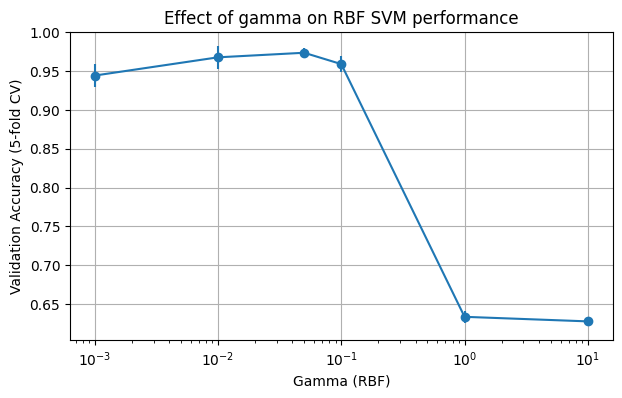

In [25]:
gamma_values = [0.001, 0.01 ,0.05, 0.1, 1, 10]
results_gamma = []

for g in gamma_values:
    svm = SVC(kernel="rbf", gamma=g, C=1, random_state=RNG)
    scores = cross_val_score(svm, X_train_s, y_train, cv=cv, scoring="accuracy")
    results_gamma.append((g, scores.mean(), scores.std()))

df_gamma = pd.DataFrame(results_gamma, columns=["gamma", "mean_acc", "std_acc"])
display(df_gamma)
df_gamma.to_csv(OUTPUTS / "svm_gamma_results.csv", index=False)

plt.figure(figsize=(7,4))
plt.errorbar(df_gamma["gamma"], df_gamma["mean_acc"], yerr=df_gamma["std_acc"], fmt='-o')
plt.xscale("log")
plt.xlabel("Gamma (RBF)")
plt.ylabel("Validation Accuracy (5-fold CV)")
plt.title("Effect of gamma on RBF SVM performance")
plt.grid(True)
savefig("effect_gamma_on_RBF_SVM")
plt.show()


γ controls how much each datapoint influence the decision boundary.

γ=0.05 is therefore best, because it gives the highest accuracy on 0.973615

##### Bias–Variance Trade-off
Bias measures how far the model’s average prediction is from the true value. Variance measures how much the model’s predictions change when you train it on different subsets of data.

Low γ (0.001–0.01)
-> The model is smoother and less flexible, showing high bias and low variance.
Accuracy is good but not optimal since the model underfits slightly.

Moderate γ (0.05–0.1)
-> The model captures more complex patterns without overfitting.
Bias and variance are balanced, and performance peaks at γ = 0.05, with the highest mean accuracy (0.9736 ± 0.0058).

High γ (1–10)
-> The model becomes too sensitive to individual samples, creating very sharp decision boundaries.
This leads to low bias but very high variance, causing overfitting and a steep drop in validation accuracy (to around 0.63).